In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import  preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [149]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [150]:
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

In [151]:
mainpath="../NSL-KDD/"
transformed_datasets_folder = "transformed_datasets/"
file_complete_traffic = "complete_traffic.csv"
csv_path = mainpath + transformed_datasets_folder + file_complete_traffic

In [152]:
df = pd.read_csv(csv_path)
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,1,20,9,491.0,0.0,0,0.0,0.0,0.0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0.0,2,44,9,146.0,0.0,0,0.0,0.0,0.0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0.0,1,49,5,0.0,0.0,0,0.0,0.0,0.0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0.0,1,24,9,232.0,8153.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0.0,1,24,9,199.0,420.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


In [153]:
np_array = df.to_numpy()
class_label = np_array[:, -1] # for last column
data = np_array[:, :-1] # for all but last column

In [154]:
X_train, X_test, y_train, y_test = train_test_split(data, class_label, test_size=0.1, random_state=42)
print(len(data))
print(len(X_train))

148517
133665


In [155]:
# 0,9*0,23 = 0,207
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.23, random_state=42)
print(len(X_val))
print(len(X_train))

30743
102922


In [156]:
y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [157]:
X_train = preprocessing.normalize(X_train,norm='l2')
X_test = preprocessing.normalize(X_test,norm='l2')
X_val = preprocessing.normalize(X_val,norm='l2')

In [158]:
# Parametros de la red
batch_size = 64
epochs = 50
hidden_units_1 = 16
hidden_units_2 = 8
hidden_units_3 = 8
hidden_units_4 = 64
num_labels = len(np.unique(y_train, return_counts=False))
input_size = data.shape[1]
activation_type = "relu"
kernel_init = "glorot_uniform"
patience = 5
regularization_parameter = 0.0001
dropout_parameter = 0.4


In [159]:
model = Sequential([
    Dense(hidden_units_1, input_dim=input_size, activation=activation_type, kernel_initializer=kernel_init,  
          kernel_regularizer=tf.keras.regularizers.l1(regularization_parameter)
      ),
    Dropout(dropout_parameter),
    Dense(hidden_units_2, activation=activation_type, kernel_initializer=kernel_init, 
          kernel_regularizer=tf.keras.regularizers.l1(regularization_parameter) 
    ),
    #Dropout(dropout_parameter),
    #Dense(hidden_units_3, activation=activation_type, kernel_initializer=kernel_init,
    #      kernel_regularizer=tf.keras.regularizers.l1(0.005)
    #),
    #Dense(hidden_units_4, activation=activation_type, kernel_initializer=kernel_init),
    Dense(num_labels, activation='softmax')
])

In [160]:
model.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])

In [161]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

In [162]:
history = model.fit(X_train, y_train, 
              epochs=epochs, 
              validation_data=(X_val, y_val),
              batch_size=batch_size,
              callbacks=[es]
          )

Epoch 1/50
1609/1609 [==============================] - 7s 4ms/step - loss: 0.3092 - accuracy: 0.8764 - val_loss: 0.2180 - val_accuracy: 0.9242
Epoch 2/50
1609/1609 [==============================] - 7s 4ms/step - loss: 0.2304 - accuracy: 0.9114 - val_loss: 0.1874 - val_accuracy: 0.9349
Epoch 3/50
1609/1609 [==============================] - 7s 4ms/step - loss: 0.2098 - accuracy: 0.9187 - val_loss: 0.1725 - val_accuracy: 0.9391
Epoch 4/50
1609/1609 [==============================] - 8s 5ms/step - loss: 0.1979 - accuracy: 0.9222 - val_loss: 0.1634 - val_accuracy: 0.9388
Epoch 5/50
1609/1609 [==============================] - 7s 5ms/step - loss: 0.1912 - accuracy: 0.9253 - val_loss: 0.1571 - val_accuracy: 0.9370
Epoch 6/50
1609/1609 [==============================] - 8s 5ms/step - loss: 0.1838 - accuracy: 0.9280 - val_loss: 0.1499 - val_accuracy: 0.9459
Epoch 7/50
1609/1609 [==============================] - 7s 4ms/step - loss: 0.1774 - accuracy: 0.9305 - val_loss: 0.1493 - val_accuracy:

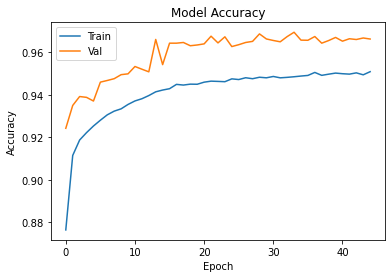

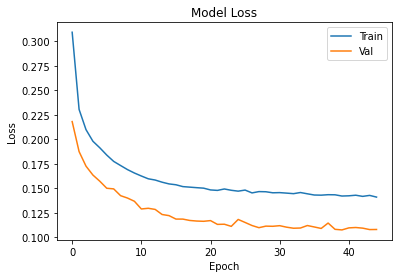

In [163]:
plot_acc(history)
plot_loss(history)

In [175]:
y_test_cat = to_categorical(y_test)
_, acc = model.evaluate(X_test, y_test_cat, batch_size=batch_size)
print("Accuracy Test sample: %.1f%%" % (100.0 * acc))

233/233 [==============================] - 1s 3ms/step - loss: 0.1125 - accuracy: 0.9653
Accuracy Test sample: 96.5%


In [169]:
# predict crisp classes for test set
y_predicted_classes = np.argmax(model.predict(X_test), axis=-1)

In [173]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_predicted_classes)
print("Accuracy Test sample: %.1f%%" % (100.0 * accuracy))

# precision tp / (tp + fp)
precision = precision_score(y_test, y_predicted_classes)
print("Precision Test sample: %.1f%%" % (100.0 * precision))

# recall: tp / (tp + fn)
recall = recall_score(y_test, y_predicted_classes)
print("Recall Test sample: %.1f%%" % (100.0 * recall))

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_predicted_classes)
print("F1 score Test sample: %.1f%%" % (100.0 * f1))

Accuracy Test sample: 96.5%
Precision Test sample: 98.5%
Recall Test sample: 94.2%
F1 score Test sample: 96.3%
